# Lab: SVD and PCA

## 1 SVD and PCA basics

In [1]:
import numpy as np

a = np.array([
    [17, 24, 1, 8, 15],
    [23, 5, 7, 14, 16],
    [4, 6, 13, 20, 22],
    [10, 12, 19, 21, 3],
    [11, 18, 25, 2, 9]
], dtype=float)

### Exercise 1

In [3]:
x, s, y = np.linalg.svd(a)

explained_var = s ** 2 / np.sum(s ** 2)
print(f'Explained variance = {explained_var}')

Explained variance = [0.76470588 0.09201289 0.08513021 0.03251685 0.02563417]


According to the [NumPy documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html), `np.linalg.svd` returns the Hermitian transpose of $V$, which is the transpose of $V$ for real matrices. We can see that treating `y` as $V^T$ gives the correct reconstruction, and treating `y` as $V$ does not.

In [6]:
sigma = np.zeros_like(a)
np.fill_diagonal(sigma, s)

print('Correct (y = V^T)')
print(x @ sigma @ y)
print()

print('Incorrect (y = V)')
print(x @ sigma @ y.T)

Correct (y = V^T)
[[17. 24.  1.  8. 15.]
 [23.  5.  7. 14. 16.]
 [ 4.  6. 13. 20. 22.]
 [10. 12. 19. 21.  3.]
 [11. 18. 25.  2.  9.]]

Incorrect (y = V)
[[ 14.76140681  23.07906839 -15.73687265  12.03822041  -3.4481241 ]
 [ 19.59371802   5.75040259 -10.94388017  22.75873899  -0.53886058]
 [ 15.34302925   0.46199784 -12.78540028  17.1745351  -20.27182516]
 [ 16.33151316  10.89095607   5.69931752  19.1526371  -16.44271953]
 [ -1.02966724  18.61178131  -2.0699959   25.19939361 -12.97100847]]


In [9]:
b = x @ sigma @ y
print(f'All components close? {np.allclose(b, a)}')
print(f'Frobenius norm of difference = {np.linalg.norm(a - b)}')

All components close? True
Frobenius norm of difference = 8.523187293941492e-14


Project $A$ to the first two principal components.

In [25]:
w = y.T[:, :2]
ar = a @ w
print(ar)

[[-2.90688837e+01 -1.23024779e+01]
 [-2.90688837e+01 -1.01407417e+01]
 [-2.90688837e+01 -5.31241717e-13]
 [-2.90688837e+01  1.01407417e+01]
 [-2.90688837e+01  1.23024779e+01]]


### Exercise 2

In [26]:
from sklearn.decomposition import PCA

pca = PCA(2)
pca.fit(a)
ar2 = pca.transform(a)
print(ar2)

[[ 1.23024779e+01 -1.10967458e+01]
 [ 1.01407417e+01  4.23857973e+00]
 [-6.25055563e-14  1.37163321e+01]
 [-1.01407417e+01  4.23857973e+00]
 [-1.23024779e+01 -1.10967458e+01]]


Variance explained by each component:

In [29]:
print(pca.explained_variance_ratio_)

[0.39105478 0.3618034 ]


The reduced matrix is not the same -- `PCA` *centers* the data before performing the SVD.

In [33]:
pca_full = PCA(5).fit(a)
print(np.cumsum(pca_full.explained_variance_ratio_))

[0.39105478 0.75285817 0.89105478 1.         1.        ]


Looking at the cumulative sum of the explained variance ratios, we see that 3 components are necessary to explain at least 80% of the variance.

### Exercise 3

Center the data.

In [35]:
a_center = a - np.mean(a, axis=1, keepdims=True)

Now do the SVD analysis.

In [37]:
x, s, y = np.linalg.svd(a_center)
sigma = np.zeros_like(a)
np.fill_diagonal(sigma, s)

w = y.T[:, :2]
ar3 = a @ w
print(ar3)

[[-1.23024779e+01  1.10967458e+01]
 [-1.01407417e+01 -4.23857973e+00]
 [ 5.97299987e-14 -1.37163321e+01]
 [ 1.01407417e+01 -4.23857973e+00]
 [ 1.23024779e+01  1.10967458e+01]]


The reduced matrix is the same as that returned by Scikit-Learn (up to sign, which is OK because singular vectors are only defined up to a constant multiple).

In [38]:
print(f'All components close with same sign? {np.allclose(ar3, ar2)}')
print(f'All components close with opposite sign? {np.allclose(ar3, -ar2)}')

All components close with same sign? False
All components close with opposite sign? True


##  2 SVD and PCA for image compression

Load image, split into channels, and display to make sure we loaded it correctly.

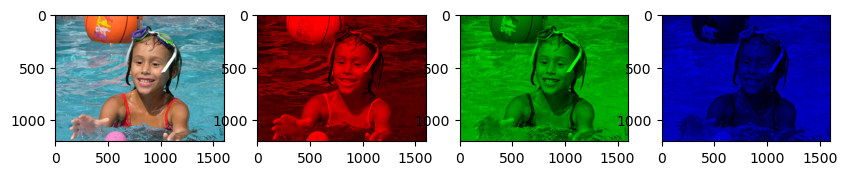

In [58]:
import imageio
import matplotlib.pyplot as plt

image = imageio.v3.imread('swim.jpg')
red, green, blue = image.transpose((2, 0, 1))[:3]

projections = (
    lambda im: im, 
    lambda im: im[..., None] * np.array([1, 0, 0]).reshape(1, 1, 3),
    lambda im: im[..., None] * np.array([0, 1, 0]).reshape(1, 1, 3),
    lambda im: im[..., None] * np.array([0, 0, 1]).reshape(1, 1, 3),
)

_, axes = plt.subplots(1, 4, figsize=(10, 6))
for ax, channel, proj in zip(axes, (image, red, green, blue), projections):
    ax.imshow(proj(channel))

### Exercise 4

Let $A$ be one channel of our image. To compute the rank-$k$ approximation $A^{(k)}$ of $A$, we use the sum
$$
\tag{1}
A^{(k)} = \sum_{j=1}^k \sigma_j A_j,
$$
where $A_j = u_j \otimes v_j = u_jv_j^T$, the outer product of the left and right singular vectors $u_j$ and $v_j$ of $A$ corresponding to the singular value $\sigma_j$, which is the $j$-th largest.

We can rewrite (1) as
$$
A^{(k)} = \left[\begin{matrix}u_1 & u_2 & \cdots & u_k\end{matrix}\right] \left[\begin{matrix}\sigma_1 & 0 &  \cdots & 0 \\ 0 & \sigma_2 &  \cdots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 &  0 & \cdots & \sigma_k\end{matrix}\right]\left[\begin{matrix}v_1^T \\ v_2^T\\\vdots\\v_k^T\end{matrix}\right].
$$
If $U$, $d$, and $V^T$ are the matrices returned by `np.linalg.svd`, then $\{u_j\}$ are the first $k$ columns of $U$, $\{v_j^T\}$ are the first $k$ rows of $V^T$, and $\{\sigma_j\}$ are the first $k$ elements of $d$. Therefore, equation (1) becomes
$$
A^{(k)} = U_k \mathrm{diag}_k(d) V_k^T
$$
where $U_k$ is $U$ truncated to the first $k$ columns, $\mathrm{diag}_k(d)$ is the diagonal matrix with diagonal values taken from the first $k$ values of $d$, and $V_k^T$ is $V^T$ truncated to the first $k$ rows.

In [16]:
import numpy as np

def reduced_image(k):
    reduced = []
    for channel in (red, green, blue):
        u, d, vt = np.linalg.svd(channel.astype(float), full_matrices=False)
        reduced.append(u[:, :k] @ np.diag(d[:k]) @ vt[:k])
    return np.clip(np.stack(reduced, 0, 255, axis=-1), 0, 255).astype(np.uint8)
    

In [22]:
reduced_image_20 = reduced_image(20)

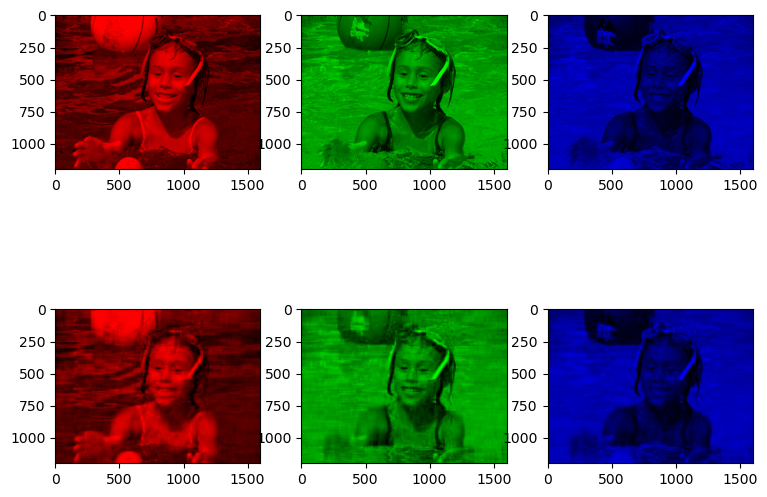

In [59]:
_, axes = plt.subplots(2, 3, figsize=(9, 7))
for row_axes, row_image in zip(axes, (image, reduced_image_20)):
    for ax, channel, proj in zip(row_axes, row_image.transpose((2, 0, 1)), projections[1:]):
        ax.imshow(proj(channel))
plt.show()

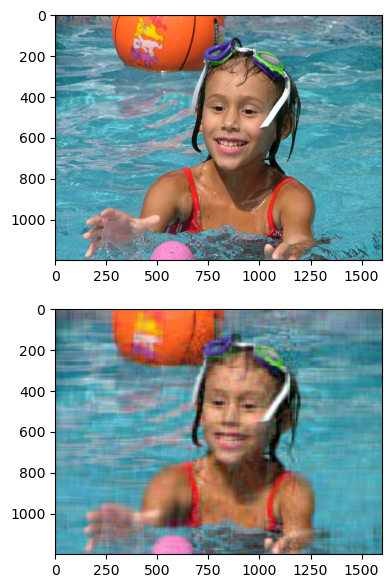

In [24]:
_, axes = plt.subplots(2, 1, figsize=(6, 7))
for ax, im in zip(axes, (image, reduced_image_20)):
    ax.imshow(im)

### Exercise 5

In [26]:
from sklearn.decomposition import PCA

def reduced_image_pca(k):
    reduced = []
    for channel in (red, green, blue):
        pca = PCA(k)
        low_dim = pca.fit_transform(channel.astype(float))
        reduced.append(pca.inverse_transform(low_dim))
    return np.clip(np.stack(reduced, axis=-1), 0, 255).astype(np.uint8)        

In [27]:
reduced_image_pca_10 = reduced_image_pca(10)

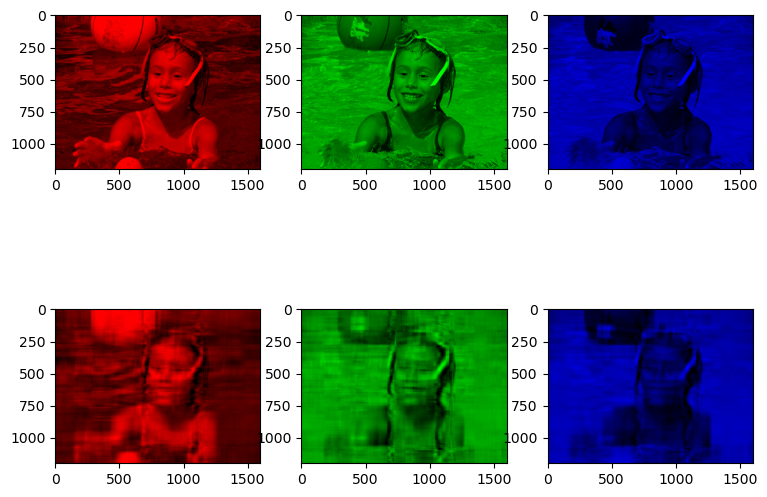

In [60]:
_, axes = plt.subplots(2, 3, figsize=(9, 7))
for row_axes, row_image in zip(axes, (image, reduced_image_pca_10)):
    for ax, channel, proj in zip(row_axes, row_image.transpose((2, 0, 1)), projections[1:]):
        ax.imshow(proj(channel))
plt.show()

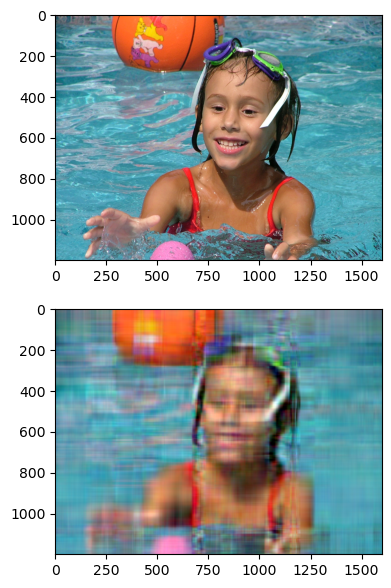

In [30]:
_, axes = plt.subplots(2, 1, figsize=(6, 7))
for ax, im in zip(axes, (image, reduced_image_pca_10)):
    ax.imshow(im)

## 3 PCA for dimensionality reduction

### Exercise 6

In [46]:
import pandas
df = pandas.read_csv('diagnosis.csv')
df.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


Since we are going to use the reduced data for classification, we should exclude the **diagnosis** feature from the PCA dimension reduction. We also need to exclude the erroneously loaded **Unnamed: 32** feature, and the useless **id** feature.

In [47]:
diagnosis = np.array([1. if d == 'M' else 0. for d in df['diagnosis']])
df = df.drop('diagnosis', axis=1)
df = df.drop('Unnamed: 32', axis=1)
df = df.drop('id', axis=1)
df.head(5)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Use PCA to reduce the dimensionality of the input features.

In [48]:
diagnosis_pca = PCA(2).fit(df)
dfr = diagnosis_pca.transform(df)

Create training and testing splits from the **reduced** data.

In [49]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(dfr, diagnosis, test_size=.25, random_state=20)

Fit a logistic regression model to the training data.

In [50]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(x_train, y_train)

Compute confusion matrices of the model on training and testing data.

In [51]:
from sklearn.metrics import confusion_matrix

for x, y, name in [(x_train, y_train, 'train'), (x_test, y_test, 'test')]:
    y_pred = model.predict(x)
    print(f'Confusion matrix for {name}')
    print(confusion_matrix(y, y_pred))
    print()

Confusion matrix for train
[[261  10]
 [ 20 135]]

Confusion matrix for test
[[84  2]
 [ 7 50]]



### Exercise 7

Normalize reduced data computed in the previous exercise.

In [52]:
from sklearn.preprocessing import MinMaxScaler

dfr_norm = MinMaxScaler().fit_transform(dfr)

Now split the normalized data.

In [53]:
from sklearn.model_selection import train_test_split

x_train_n, x_test_n, y_train_n, y_test_n = train_test_split(dfr_norm, diagnosis, test_size=.25, random_state=20)

Fit a logistic regression to the normalized, reduced data.

In [54]:
from sklearn.linear_model import LogisticRegression

model_n = LogisticRegression().fit(x_train_n, y_train_n)

Compute confusion matrices for the training and testing data.

In [55]:
from sklearn.metrics import confusion_matrix

for x, y, name in [(x_train_n, y_train_n, 'train'), (x_test_n, y_test_n, 'test')]:
    y_pred = model_n.predict(x)
    print(f'Confusion matrix for {name}')
    print(confusion_matrix(y, y_pred))
    print()

Confusion matrix for train
[[270   1]
 [ 60  95]]

Confusion matrix for test
[[86  0]
 [20 37]]

